# Preprocess data 
Preprocess and save data as .pkl format for training 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)

## Import data into Pandas dataframe

In [2]:
data = pd.read_csv('data/training_set.csv')
metadata = pd.read_csv('data/training_set_metadata.csv')

filt = 'ugrizy'
filtint = np.arange(len(filt))

obj_id = np.unique(data['object_id'])
N = obj_id.size

Pick a sample object and apply data reduction 

In [3]:
sample_obj = data[data['object_id'] == obj_id[10]]

mjd = sample_obj['mjd'].values
band = sample_obj['passband'].values
flux = sample_obj['flux'].values
flux_err = sample_obj['flux_err'].values

## Time series from data

Apply a passband cut and plot flux vs. scaled time

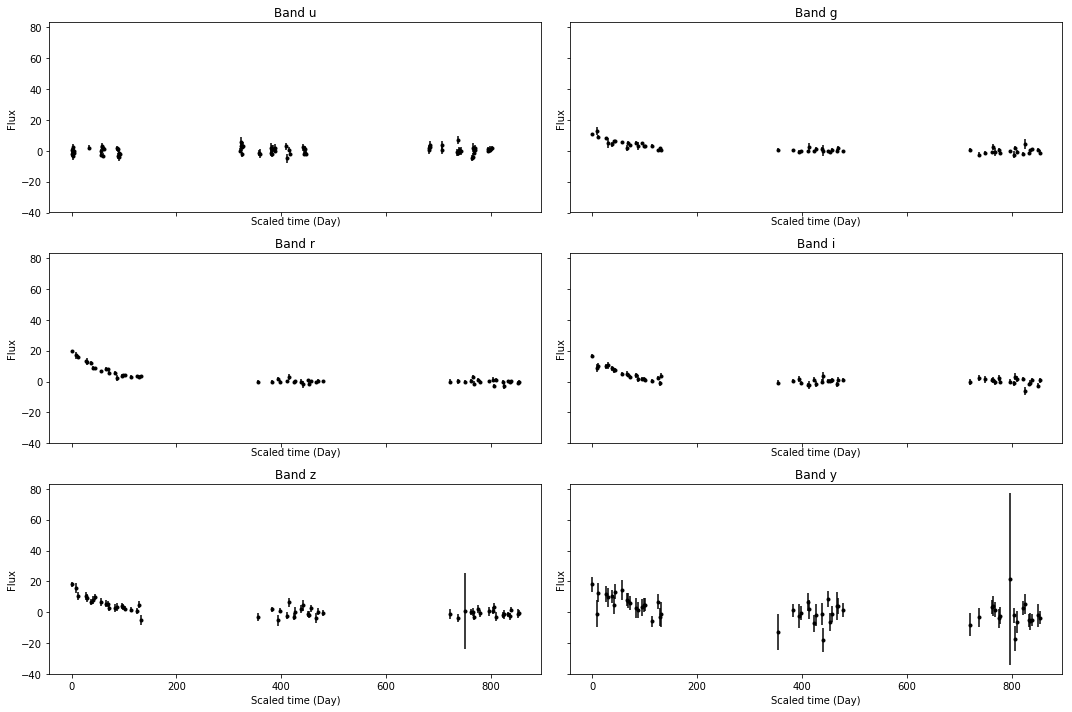

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)

for id_b, b in enumerate(filt):
    
    # bandpass cut
    mask = (band == filtint[id_b])
    t = mjd[mask]
    t = t - t.min()
    f = flux[mask]
    errf = flux_err[mask]
    
    # plot
    ax = axes.flatten()[id_b]
    ax.errorbar(t, f, yerr=errf, fmt='k.', label=b)
    ax.set(xlabel='Scaled time (Day)', ylabel='Flux', title='Band %s'%b)
    
fig.tight_layout()

Because each series have different length, apply zero padding. First we must find the maximum length of all series

In [5]:
nmax = -1
for id_i, i in enumerate(obj_id):
    sample_obj = data[data['object_id'] == i]

    mjd = sample_obj['mjd'].values
    band = sample_obj['passband'].values
     
    for id_b, b in enumerate(filt):

        # bandpass cut
        mask = (band == filtint[id_b])
        n = np.sum(mask)
        
        nmax = n if n > nmax else nmax

In [6]:
X = np.zeros((N, nmax, len(filt)*2))
for id_i, i in enumerate(obj_id):
    sample_obj = data[data['object_id'] == i]

    mjd = sample_obj['mjd'].values
    band = sample_obj['passband'].values
    flux = sample_obj['flux'].values
    flux_err = sample_obj['flux_err'].values     

    for id_b, b in enumerate(filt):

        # bandpass cut
        mask = (band == filtint[id_b])
        t = mjd[mask]
        t = t - t.min()
        f = flux[mask]
        ferr = flux_err[mask]
        
        padwidth = (0, nmax-t.size)
        
        X[id_i, :, id_b] = np.pad(f, padwidth, mode='constant', constant_values=0)
        X[id_i, :, len(filt)+id_b] = np.pad(ferr, padwidth, mode='constant', constant_values=0)

### Feature vector and label from metadata

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

metaX = np.zeros((N, 8))
metaX[:, 0] = metadata['ra'].values
metaX[:, 1] = metadata['decl'].values
metaX[:, 2] = metadata['gal_l'].values
metaX[:, 3] = metadata['gal_b'].values
metaX[:, 4] = metadata['hostgal_specz'].values
metaX[:, 5] = metadata['hostgal_photoz'].values
metaX[:, 6] = metadata['hostgal_photoz_err'].values
metaX[:, 7] = metadata['mwebv'].values

# define example
yraw = metadata['target']
ylabel = LabelEncoder().fit_transform(yraw)
y = OneHotEncoder(sparse=False).fit_transform(ylabel.reshape(-1, 1))

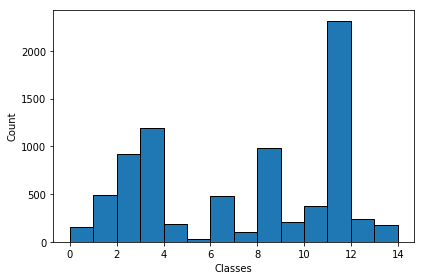

In [16]:
fig, ax = plt.subplots(1)

ax.hist(ylabel, edgecolor='k', bins=np.arange(15))
ax.set(xlabel='Classes', ylabel='Count')

fig.tight_layout()

plt.savefig('class_distribution.png', dpi=100, bbox_inches='tight')

## Save object

In [8]:
import pickle

data_dict = {'X': X, 'y': y, 'metaX': metaX}
with open('training_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f, protocol=-1)